In [1]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff
using Optim

In [2]:
function toy_PoissonLDS()
    T = 100
    # create a PLDS model
    x0 = [1.0, -1.0]
    p0 = Matrix(Diagonal([0.1, 0.1]))
    A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
    Q = Matrix(Diagonal([0.1, 0.1]))
    C = [0.5 0.5; 0.5 0.1; 0.9 0.1]
    log_d = log.([0.1, 0.05, 1])
    D = Matrix(Diagonal([0., 0., 0.]))
    b = ones(T, 2) * 0.00

    plds = PoissonLDS(A=A, C=C, Q=Q, D=D, b=b, log_d=log_d, x0=x0, p0=p0, refractory_period=1, obs_dim=3, latent_dim=2)
    # sample data
    x, y = SSM.sample(plds, T, 3)
    return plds, x, y
end

plds, x, y_array = toy_PoissonLDS()
plds.fit_bool = [true, true, true, true, true, true]

b = ones(100, 2) * 0.000;
# plds.A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
# plds.Q = Matrix(Diagonal([1., 1.]))
# plds.x0 = [0.0, -0.0]
# plds.p0 = Matrix{Float64}([1. 0; 0 1.])

100×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [4]:
SSM.fit!(plds, y_array, 2)

ArgumentError: ArgumentError: matrix contains Infs or NaNs

In [7]:
plds.C

3×2 Matrix{Float64}:
 1.20545  0.98404
 1.35706  0.929379
 1.1095   0.245278

In [12]:
# define a function that wraps the loglikelihood function
function likelihood_wrapper(vec_x::Vector{<:Real})
    # Calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct from
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the loglikelihood
    return -SSM.logposterior(x, plds, y)
end

# define a function that wraps the gradient of the loglikelihood function
function gradient!(G::Vector{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the gradient
    G .= vec(permutedims(-SSM.Gradient(x, plds, y)))
end

# define a function that wraps the hessian of the loglikelihood function
function hessian!(H::Matrix{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the hessian
    hess, _, _, _ = SSM.Hessian(x, plds, y)
    H .= -hess
end

# init guess
x0 = zeros(200)
y = y_array[3, :, :]

res = optimize(likelihood_wrapper, gradient!, hessian!, x0)

 * Status: success

 * Candidate solution
    Final objective value:     -4.974156e+03

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.19e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.49e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.28e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 5.36e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    24
    ∇f(x) calls:   24
    ∇²f(x) calls:  7


In [7]:
x_new = SSM.interleave_reshape(res.minimizer, 100, 2)

100×2 Matrix{Float64}:
 0.818803  -0.505183
 1.0888    -0.869092
 1.00775   -1.67825
 1.32243   -2.1677
 1.6667    -2.26547
 2.28964   -2.61679
 2.77547   -2.41452
 2.52389   -2.22462
 2.77324   -2.00848
 2.54326   -2.05983
 ⋮         
 2.2561    -1.859
 1.2725    -1.46888
 1.32627   -1.07616
 2.26908   -1.28299
 1.76964   -1.22193
 2.20769   -1.44578
 2.68592   -1.19145
 2.72206   -1.67097
 3.18873   -1.6681

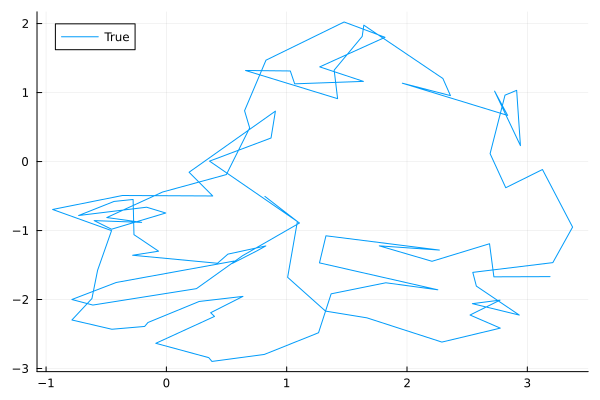

In [15]:
plot(x_new[:, 1], x_new[:, 2], label="True")

In [10]:
grad = SSM.Gradient(x_new, plds, y)

maximum(grad)

8.311129562343922e-13